In [2]:
import os
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import save_image
import torchvision
import torch.nn.functional as F

from IPython.display import Image

In [3]:
# Random seed 
torch.manual_seed(10001)

bs = 32

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def flatten(x):
    return to_var(x.view(x.size(0), -1))

def save_image(x, path='real_image.png'):
    torchvision.utils.save_image(x, path)

In [4]:

# Load Data
dataset = datasets.MNIST(root='/mnist_data', train=True, transform=transforms.ToTensor(), download=True)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

In [5]:
if not os.path.exists('/reconstructed'):
    os.makedirs('/reconstructed')

In [6]:
# Some prechecks on data loader

In [7]:
batch = list(data_loader)[0]
img,tar = batch
print(img.shape,tar.shape)
# [bs,c,h,w]

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [8]:
# Fixed input for debugging
fixed_x, _ = next(iter(data_loader))
save_image(fixed_x)
fixed_x = flatten(fixed_x)
fixed_x.shape   # [bs,h*w]

torch.Size([32, 784])

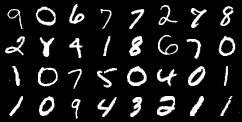

In [9]:
Image('real_image.png')

In [10]:
class VAE(nn.Module):
    def __init__(self, in_dim = 784, hidden_dim = 128, n_layers = 2, out_dim =784 ,z_dim= 10):
        
        super(VAE, self).__init__()
        
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim
        
        self.encoder_lstm = nn.LSTM(in_dim, hidden_dim, n_layers, batch_first=True)
                                          
        self.encoder_output = nn.Linear(hidden_dim, z_dim*2)
        
        self.decoder_lstm = nn.LSTM(z_dim, hidden_dim, n_layers, batch_first=True)
                                     
        self.decoder_output = nn.Linear(hidden_dim, in_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
                                     
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
                                          
    def forward(self, x):
        
        # Encoder
        enc_hidden = self._init_hidden()
        enc,_ = self.encoder_lstm(x,enc_hidden)
        enc = self.relu(enc)

        # Reparameterize
        z_var = self.encoder_output(enc)    
        mu,logvar = torch.chunk(z_var, 2, dim=2)   # [bs,c,z_var]  [128,1,10]    
        z = self.reparameterize(mu, logvar)
        
        # Decoder
        dec_hidden = self._init_hidden()
        dec,_ = self.decoder_lstm(z,dec_hidden)
        dec = self.relu(dec)
        dec = self.sigmoid(self.decoder_output(dec))
        
        return dec, mu, logvar
    
    
    def _init_hidden(self):
        return torch.zeros(self.n_layers, bs, self.hidden_dim).cuda(), torch.zeros(self.n_layers, bs, self.hidden_dim).cuda()
        

In [11]:
vae = VAE()
if torch.cuda.is_available():
    vae.cuda()
vae

VAE(
  (encoder_lstm): LSTM(784, 128, num_layers=2, batch_first=True)
  (encoder_output): Linear(in_features=128, out_features=20, bias=True)
  (decoder_lstm): LSTM(10, 128, num_layers=2, batch_first=True)
  (decoder_output): Linear(in_features=128, out_features=784, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [12]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [13]:
def loss_fn(recon_x, x, mu, logvar,eps):
    BCE = F.binary_cross_entropy(recon_x + eps, x, size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD

In [15]:
epochs = 1
eps = torch.Tensor([1e-10]).cuda()

for epoch in range(epochs):
    for idx, (images, _) in enumerate(data_loader):
        
        images = flatten(images)  # [bs,inp_dim]
        images = images.unsqueeze(1) # [bs,1,inp_dim]  since LSTM requires 3 dims 

        recon_images, mu, logvar = vae(images)
        loss = loss_fn(recon_images, images, mu, logvar,eps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
#         if idx%100 == 0:
#             print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.item()/bs))
    
#             recon_x, mu, logvar = vae(fixed_x.unsqueeze(1))
#             save_image(recon_x.view(recon_x.size(0), 1, 28, 28).data.cpu(), f'recon_image_{epoch}_{idx}.png')
            

0 torch.Size([32, 1, 784])
1 torch.Size([32, 1, 784])
2 torch.Size([32, 1, 784])
3 torch.Size([32, 1, 784])
4 torch.Size([32, 1, 784])
5 torch.Size([32, 1, 784])
6 torch.Size([32, 1, 784])
7 torch.Size([32, 1, 784])
8 torch.Size([32, 1, 784])
9 torch.Size([32, 1, 784])
10 torch.Size([32, 1, 784])
11 torch.Size([32, 1, 784])
12 torch.Size([32, 1, 784])
13 torch.Size([32, 1, 784])
14 torch.Size([32, 1, 784])
15 torch.Size([32, 1, 784])
16 torch.Size([32, 1, 784])
17 torch.Size([32, 1, 784])
18 torch.Size([32, 1, 784])
19 torch.Size([32, 1, 784])
20 torch.Size([32, 1, 784])
21 torch.Size([32, 1, 784])
22 torch.Size([32, 1, 784])
23 torch.Size([32, 1, 784])
24 torch.Size([32, 1, 784])
25 torch.Size([32, 1, 784])
26 torch.Size([32, 1, 784])
27 torch.Size([32, 1, 784])
28 torch.Size([32, 1, 784])
29 torch.Size([32, 1, 784])
30 torch.Size([32, 1, 784])
31 torch.Size([32, 1, 784])
32 torch.Size([32, 1, 784])
33 torch.Size([32, 1, 784])
34 torch.Size([32, 1, 784])
35 torch.Size([32, 1, 784])
36

568 torch.Size([32, 1, 784])
569 torch.Size([32, 1, 784])
570 torch.Size([32, 1, 784])
571 torch.Size([32, 1, 784])
572 torch.Size([32, 1, 784])
573 torch.Size([32, 1, 784])
574 torch.Size([32, 1, 784])
575 torch.Size([32, 1, 784])
576 torch.Size([32, 1, 784])
577 torch.Size([32, 1, 784])
578 torch.Size([32, 1, 784])
579 torch.Size([32, 1, 784])
580 torch.Size([32, 1, 784])
581 torch.Size([32, 1, 784])
582 torch.Size([32, 1, 784])
583 torch.Size([32, 1, 784])
584 torch.Size([32, 1, 784])
585 torch.Size([32, 1, 784])
586 torch.Size([32, 1, 784])
587 torch.Size([32, 1, 784])
588 torch.Size([32, 1, 784])
589 torch.Size([32, 1, 784])
590 torch.Size([32, 1, 784])
591 torch.Size([32, 1, 784])
592 torch.Size([32, 1, 784])
593 torch.Size([32, 1, 784])
594 torch.Size([32, 1, 784])
595 torch.Size([32, 1, 784])
596 torch.Size([32, 1, 784])
597 torch.Size([32, 1, 784])
598 torch.Size([32, 1, 784])
599 torch.Size([32, 1, 784])
600 torch.Size([32, 1, 784])
601 torch.Size([32, 1, 784])
602 torch.Size

1128 torch.Size([32, 1, 784])
1129 torch.Size([32, 1, 784])
1130 torch.Size([32, 1, 784])
1131 torch.Size([32, 1, 784])
1132 torch.Size([32, 1, 784])
1133 torch.Size([32, 1, 784])
1134 torch.Size([32, 1, 784])
1135 torch.Size([32, 1, 784])
1136 torch.Size([32, 1, 784])
1137 torch.Size([32, 1, 784])
1138 torch.Size([32, 1, 784])
1139 torch.Size([32, 1, 784])
1140 torch.Size([32, 1, 784])
1141 torch.Size([32, 1, 784])
1142 torch.Size([32, 1, 784])
1143 torch.Size([32, 1, 784])
1144 torch.Size([32, 1, 784])
1145 torch.Size([32, 1, 784])
1146 torch.Size([32, 1, 784])
1147 torch.Size([32, 1, 784])
1148 torch.Size([32, 1, 784])
1149 torch.Size([32, 1, 784])
1150 torch.Size([32, 1, 784])
1151 torch.Size([32, 1, 784])
1152 torch.Size([32, 1, 784])
1153 torch.Size([32, 1, 784])
1154 torch.Size([32, 1, 784])
1155 torch.Size([32, 1, 784])
1156 torch.Size([32, 1, 784])
1157 torch.Size([32, 1, 784])
1158 torch.Size([32, 1, 784])
1159 torch.Size([32, 1, 784])
1160 torch.Size([32, 1, 784])
1161 torch

1674 torch.Size([32, 1, 784])
1675 torch.Size([32, 1, 784])
1676 torch.Size([32, 1, 784])
1677 torch.Size([32, 1, 784])
1678 torch.Size([32, 1, 784])
1679 torch.Size([32, 1, 784])
1680 torch.Size([32, 1, 784])
1681 torch.Size([32, 1, 784])
1682 torch.Size([32, 1, 784])
1683 torch.Size([32, 1, 784])
1684 torch.Size([32, 1, 784])
1685 torch.Size([32, 1, 784])
1686 torch.Size([32, 1, 784])
1687 torch.Size([32, 1, 784])
1688 torch.Size([32, 1, 784])
1689 torch.Size([32, 1, 784])
1690 torch.Size([32, 1, 784])
1691 torch.Size([32, 1, 784])
1692 torch.Size([32, 1, 784])
1693 torch.Size([32, 1, 784])
1694 torch.Size([32, 1, 784])
1695 torch.Size([32, 1, 784])
1696 torch.Size([32, 1, 784])
1697 torch.Size([32, 1, 784])
1698 torch.Size([32, 1, 784])
1699 torch.Size([32, 1, 784])
1700 torch.Size([32, 1, 784])
1701 torch.Size([32, 1, 784])
1702 torch.Size([32, 1, 784])
1703 torch.Size([32, 1, 784])
1704 torch.Size([32, 1, 784])
1705 torch.Size([32, 1, 784])
1706 torch.Size([32, 1, 784])
1707 torch

In [2]:
checkpoint = {'model': VAE(),
          'state_dict': vae.state_dict(),
          'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

NameError: name 'VAE' is not defined

In [3]:
# Freeze the parameters and evaluate the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

vae = load_checkpoint('checkpoint.pth')

NameError: name 'torch' is not defined

In [ ]:
vae